In [3]:
import pandas as pd
import numpy as np

In [4]:
# Read csv and sample 2500 randomly
df = pd.read_csv("Train_rev1.csv")
df = df.sample(n=2500, replace=False, random_state=13)

In [ ]:
# Pandas profiling
'''
from pandas_profiling import ProfileReport
profile = ProfileReport(df, title="Pandas Profiling Report")
profile.to_file("data_profile.html")
'''

## Q1 - Only using Job Description as predictor

### Split into X and y and preprocessing

In [6]:
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,SnowballStemmer
from nltk.corpus import stopwords, words, wordnet
from nltk.classify import naivebayes
import re

In [7]:
# Some descriptions end with these text. Drop these bits off

def drop_ending1(text):
    index = text.lower().find("this job was originally posted as")
    return text[:index]
    
def drop_ending2(text):
    index = text.lower().find("send in your")
    return text[:index]    

def drop_ending3(text):
    index = text.lower().find("to apply please")
    return text[:index]

def drop_ending4(text):
    index = text.lower().find("must be eligible to")
    return text[:index]    

df['FullDescription'] = df['FullDescription'].map(lambda k:drop_ending1(k))
df['FullDescription'] = df['FullDescription'].map(lambda k:drop_ending2(k))
df['FullDescription'] = df['FullDescription'].map(lambda k:drop_ending3(k))
df['FullDescription'] = df['FullDescription'].map(lambda k:drop_ending4(k))

In [8]:
df['FullDescription'].iloc[129]
#df['FullDescription'].iloc[102]

'Matchtech are currently looking for Quality Manager to join an expanding engineering company in Norfolk. The ideal candidate must have experience withing engineering and manufacturing. Responsible to: General Manager The Person; Background in Quality Control Experience of working in a Manufacturing/Engineering environment Strong Man Management Skills Experience in a Quality Role within an Engineering/Manufacturing Environment Engineering Qualification would be advantageous Duties/Responsibilities: To collate and analyse quality data and report to management on the performance of the quality management system for review. To maintain and develop the quality management system in accordance with the requirements of the current issue of ISO 9001EN**** All its forms . Develop a measurement system to measure the Cost of Quality and report on Quality related KPI s and metrics. Manage Quality problems; collate information, assign responsibility for the investigation and ensure root causes are 

In [9]:
stopwords = stopwords.words('english') 
words = set(nltk.corpus.words.words())
wordnet = set(nltk.corpus.wordnet.words())
manywords = set.union(wordnet , words)

def preprocess(sentence):
    
    sentence=str(sentence)
    sentence = sentence.lower()
    #sentence=sentence.replace('{html}',"") 
    #sentence=sentence.replace('50embedshare',"")  # at the end of each genius lyrics for some reason
    #sentence=sentence.replace('urlcopyembedcopy',"")  # at the end of each genius lyrics for some reason

    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_num = re.sub('[0-9]+', '', cleantext)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords] #stopwords
    return " ".join(filtered_words)

# Remove non-English words   
def remove_foreign(t):
    return " ".join(w for w in nltk.wordpunct_tokenize(t) if w.lower() in manywords or not w.isalpha())


In [10]:
df['FullDescription'] = df['FullDescription'].map(lambda k:preprocess(k))
df['FullDescription'] = df['FullDescription'].apply(remove_foreign)

#df['FullDescription'] = df['FullDescription'].str.split()

In [11]:
df['FullDescription']

185474    application software engineer based cleveland ...
209332    qualified social worker birmingham currently s...
19785     job title underwriting assistant location kent...
109213    sales business development director business l...
72994     highly experiential brand marketing agency loo...
                                ...                        
67875     graduate trainee recruitment work executive se...
102346    employer local cleaning company hours per week...
169640    senior electrical engineer water wastewater fl...
186098    package per annum excellent bonus free free gy...
38008     days required reputable supportive nursing hom...
Name: FullDescription, Length: 2500, dtype: object

### Stemming

In [12]:
stemmer = SnowballStemmer('english')
df['FullDescription'] = df['FullDescription'].apply(stemmer.stem)


### Transform target variable

In [13]:
## 75% percentile here is 42500
def transform_salary(salary):
    return np.where(salary < 42500, 'low', 'high')

df['SalaryClass'] = df['SalaryNormalized'].apply(transform_salary)

Reference: https://www.nltk.org/api/nltk.classify.naivebayes.html

### Split into X/y

In [376]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

df_x = df['FullDescription']
df_y = df['SalaryClass']

x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state = 13, stratify = df_y)
x_train

24787     job working behalf one leading care offer rang...
32662     excellent media proven partnership grower look...
63204     deputy software quality assurance manager lead...
64513     produce high quality supply services order ach...
85206     currently recruiting critical engineering mana...
                                ...                        
141055    renowned city tax litigation team extending ex...
215743    leading global manufacturer within field clien...
43741     chef top rosette kitchen client stunning red s...
117308    position management accountant expanding area ...
131692    personal assistant required support man surrey...
Name: FullDescription, Length: 2000, dtype: object

In [377]:
#print(nltk.word_tokenize(x_train.iloc[0])) 

In [378]:
# Convert x_train to DF and store a list of words as another column
x_train = x_train.to_frame()
x_train['WordList'] = x_train['FullDescription'].map(lambda k: nltk.word_tokenize(k))
x_train

,FullDescription,WordList
24787,job working behalf one leading care offer rang...,"[job, working, behalf, one, leading, care, off..."
32662,excellent media proven partnership grower look...,"[excellent, media, proven, partnership, grower..."
63204,deputy software quality assurance manager lead...,"[deputy, software, quality, assurance, manager..."
64513,produce high quality supply services order ach...,"[produce, high, quality, supply, services, ord..."
85206,currently recruiting critical engineering mana...,"[currently, recruiting, critical, engineering,..."
...,...,...
141055,renowned city tax litigation team extending ex...,"[renowned, city, tax, litigation, team, extend..."
215743,leading global manufacturer within field clien...,"[leading, global, manufacturer, within, field,..."
43741,chef top rosette kitchen client stunning red s...,"[chef, top, rosette, kitchen, client, stunning..."
117308,position management accountant expanding area ...,"[position, management, accountant, expanding, ..."


In [379]:
df['SourceName'].describe()

count              2500
unique              125
top       totaljobs.com
freq                543
Name: SourceName, dtype: object

In [380]:
# List of all words in all descriptions
all_words = []

for word_list in x_train['WordList']:
    for word in word_list:
        all_words.append(word)
        
all_words

['job',
 'working',
 'behalf',
 'one',
 'leading',
 'care',
 'offer',
 'range',
 'care',
 'services',
 'nursing',
 'residential',
 'dementia',
 'mental',
 'health',
 'care',
 'currently',
 'vacancy',
 'home',
 'manager',
 'full',
 'time',
 'work',
 'one',
 'nursing',
 'south',
 'wales',
 'area',
 'successful',
 'applicant',
 'must',
 'nurse',
 'previous',
 'management',
 'experience',
 'registered',
 'welsh',
 'care',
 'council',
 'hold',
 'diploma',
 'level',
 'management',
 'due',
 'ongoing',
 'home',
 'business',
 'within',
 'area',
 'ideally',
 'looking',
 'someone',
 'previous',
 'experience',
 'raising',
 'expect',
 'market',
 'leader',
 'opportunity',
 'develop',
 'long',
 'term',
 'people',
 'care',
 'receive',
 'first',
 'class',
 'personal',
 'professional',
 'development',
 'wish',
 'discuss',
 'interested',
 'permanent',
 'available',
 'please',
 'hesitate',
 'contact',
 'advert',
 'vacancy',
 'based',
 'united',
 'kingdom',
 'process',
 'currently',
 'resident',
 'eligible

In [381]:
# Calculate frequencies of words (NOTE: ONLY WITHIN TRAIN SET to prevent info leakage) and find the top n words
word_freq = nltk.FreqDist(all_words)
word_features = list(word_freq.keys())
#list(word_freq.keys())

In [382]:
# Function to check if top n words exist
def find_features(doc):
    words = nltk.word_tokenize(doc)
    features = {}
    for w in word_features:
        features[w] = (w in words)
    return features

In [385]:
# Apply feature mapping and store in new column
x_train['FeatureMapping'] = x_train['FullDescription'].apply(find_features)
x_train

,FullDescription,WordList,FeatureMapping
24787,job working behalf one leading care offer rang...,"[job, working, behalf, one, leading, care, off...","{'job': True, 'working': True, 'behalf': True,..."
32662,excellent media proven partnership grower look...,"[excellent, media, proven, partnership, grower...","{'job': False, 'working': True, 'behalf': Fals..."
63204,deputy software quality assurance manager lead...,"[deputy, software, quality, assurance, manager...","{'job': False, 'working': False, 'behalf': Fal..."
64513,produce high quality supply services order ach...,"[produce, high, quality, supply, services, ord...","{'job': True, 'working': True, 'behalf': False..."
85206,currently recruiting critical engineering mana...,"[currently, recruiting, critical, engineering,...","{'job': False, 'working': True, 'behalf': Fals..."
...,...,...,...
141055,renowned city tax litigation team extending ex...,"[renowned, city, tax, litigation, team, extend...","{'job': False, 'working': True, 'behalf': Fals..."
215743,leading global manufacturer within field clien...,"[leading, global, manufacturer, within, field,...","{'job': False, 'working': True, 'behalf': Fals..."
43741,chef top rosette kitchen client stunning red s...,"[chef, top, rosette, kitchen, client, stunning...","{'job': False, 'working': False, 'behalf': Fal..."
117308,position management accountant expanding area ...,"[position, management, accountant, expanding, ...","{'job': False, 'working': False, 'behalf': Fal..."


In [386]:
# Add labels back to train set
x_train.reset_index(inplace=True, drop = True)
y_train.reset_index(inplace=True, drop = True)
merged_train = pd.concat([x_train,y_train], axis = 1)

### Repeat same process on test set

In [387]:
# Convert x_train to DF and store a list of words as another column
x_test = x_test.to_frame()
x_test['WordList'] = x_test['FullDescription'].map(lambda k: nltk.word_tokenize(k))

# Apply feature mapping and store in new column
x_test['FeatureMapping'] = x_test['FullDescription'].apply(find_features)
x_test

# Add labels back 
x_test.reset_index(inplace=True, drop = True)
y_test.reset_index(inplace=True, drop = True)
merged_test = pd.concat([x_test,y_test], axis = 1)


### Final Train/Test Sets

In [388]:
# Transform to an input NaiveBayesClassifier likes
train_list = merged_train[['FeatureMapping','SalaryClass']].reset_index()[['FeatureMapping', 'SalaryClass']].values.tolist()
test_list = merged_test[['FeatureMapping','SalaryClass']].reset_index()[['FeatureMapping', 'SalaryClass']].values.tolist()

train_set = []
test_set = []

for entry in train_list:
    train_set.append(tuple(entry))

for entry in test_list:
    test_set.append(tuple(entry))


## 1st Classifier - Simple preprocessing and basic text processing

In [389]:
# Implement Naive Bayes Classifier
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(f"Naive Bayes Accuracy: {nltk.classify.accuracy(classifier, test_set)*100}%")

Naive Bayes Accuracy: 78.2%


In [390]:
# See most important features
classifier.show_most_informative_features(100)

Most Informative Features
                     ceo = True             high : low    =     18.1 : 1.0
                teaching = True              low : high   =     17.1 : 1.0
                  friday = True              low : high   =     11.1 : 1.0
                    chef = True              low : high   =     10.8 : 1.0
               architect = True             high : low    =     10.7 : 1.0
                 educate = True             high : low    =     10.5 : 1.0
                  lawyer = True             high : low    =     10.5 : 1.0
                   stack = True             high : low    =     10.5 : 1.0
              conceptual = True             high : low    =      9.7 : 1.0
          transformation = True             high : low    =      9.4 : 1.0
             remediation = True             high : low    =      8.6 : 1.0
              encryption = True             high : low    =      8.6 : 1.0
              fulfilment = True             high : low    =      8.6 : 1.0

### Top 10 most important words for high salary (From most to least important)
- ceo
- architect
- educate
- lawyer
- stack
- conceptual
- transformation (common term in job titles)
- remediation (KYC - Know Your Customer Remediation)
- encryption
- cas
- fulfilment
- expat
- analyze
- hedge (hedge funds?)
- legacy
- ranking
- messaging
- paris
- metadata
- deploy (probably stemmed from 'deployment') 
- compelling 
- occasions
- browser
- certified
- locum (person who stands in for another temporarily)
- assure
- cleared
- hunter
- prove

- warehousing (data warehousing?)
- banking
- prove
- backing
- bridging
- sun (Sun Microsystems?) (probably the company?)
- upstream
- optimize
- payable
- metadata

### Top 10 most important words for low salary (From most to least important)
- teaching
- friday
- chef
- kitchen
- assistant
- school
- criminal
- duty
- charity
- teach
- license
- supervisory 

In [392]:
# Find individual predictions and store in list
to_predict = x_test['FeatureMapping'].tolist()
predictions = []
for job in to_predict:
    predictions.append(classifier.classify(job))
    
ground = y_test.tolist()


In [393]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix = confusion_matrix(ground, predictions, labels=['high','low'])
print('Confusion matrix : \n',matrix)

Confusion matrix : 
 [[ 73  56]
 [ 53 318]]


In [394]:
# outcome values order in sklearn
tp, fn, fp, tn = confusion_matrix(ground,predictions, labels=['high','low']).reshape(-1)
print(f"True Positives: {tp}\nFalse Positives: {fp}\nFalse Negatives: {fn}\nTrue Negatives {tn}")



True Positives: 73
False Positives: 53
False Negatives: 56
True Negatives 318


In [395]:
# classification report for precision, recall f1-score and accuracy
matrix = classification_report(ground,predictions, labels=['high','low'])
print('Classification report : \n',matrix)


Classification report : 
               precision    recall  f1-score   support

        high       0.58      0.57      0.57       129
         low       0.85      0.86      0.85       371

    accuracy                           0.78       500
   macro avg       0.71      0.71      0.71       500
weighted avg       0.78      0.78      0.78       500



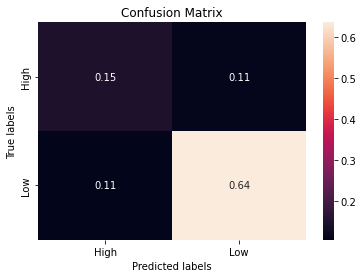

In [396]:
# Visualize confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

ax= plt.subplot()
sns.heatmap(confusion_matrix(ground, predictions,normalize = 'all'), annot = True)
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['High', 'Low']); ax.yaxis.set_ticklabels(['High', 'Low']);


plt.savefig('confusion_matrix.png')
#plt.savefig('foo.pdf')

plt.show()

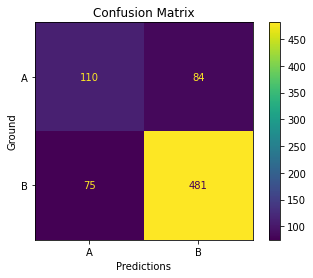

In [242]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=['high','low'])
disp.plot()
disp.ax_.set(   title='Confusion Matrix', 
                xlabel='Predictions', 
                ylabel='Ground',
                xticklabels=['High','Low'],
                yticklabels=['High','Low'])
disp.ax_.set
plt.show()

In [32]:
# Save to pickle
import pickle

nb_classifier = open("nltk_naivebayes.pickle", "wb")
pickle.dump(classifier, nb_classifier)
nb_classifier.close()

'''
classifier_f = open("nltk_naivebayes.pickle", "rb")
classifier = pickle.load(classifier_f)
classifier_f.close()
'''

'\n\n'

In [ ]:
'''# Store word frequencies in a df
word_freq_df = pd.DataFrame.from_dict(word_freq, orient = 'index')
word_freq_df.sort_values(by = 0, ascending = False)'''

## Q2 - Use other predictors as well

In [ ]:
'''# Count vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

cv = CountVectorizer(ngram_range=(1,1))
frequencies = cv.fit_transform(x_train)
cv_dataframe=pd.DataFrame(frequencies.toarray(), columns=cv.get_feature_names())

cv_dataframe.reset_index(inplace=True, drop = True)
y_train.reset_index(inplace=True, drop = True)
merged_train = pd.concat([cv_dataframe,y_train], axis = 1)
merged_train'''

In [36]:
'''# Function that returns frequencies 
def count_features(doc):
    words = nltk.word_tokenize(doc)
    features = {}
    # words - list of Str 
    for w in word_features:
        features[w] = 0
        for word in words:
            if word == w:
                features[w] += 1
    return features'''

### Incorporate other predictors

In [15]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

df_x2 = df[['FullDescription', 'ContractType', 'ContractTime', 'LocationNormalized', 'Category', 'SourceName']]
df_y2 = df['SalaryClass']

df_x_encoded = pd.get_dummies(df_x2, columns = ['ContractType','ContractTime'], drop_first = True)
df_x_encoded = pd.get_dummies(df_x_encoded, columns = ['LocationNormalized', 'Category', 'SourceName'])

x_train, x_test, y_train, y_test = train_test_split(df_x_encoded, df_y2, test_size=0.2, random_state = 13, stratify = df_y2)

x_train['WordList'] = x_train['FullDescription'].map(lambda k: nltk.word_tokenize(k))
x_train

,FullDescription,ContractType_part_time,ContractTime_permanent,LocationNormalized_Aberdeen,LocationNormalized_Aberdeenshire,LocationNormalized_Abergavenny,LocationNormalized_Accrington,LocationNormalized_Alcester,LocationNormalized_Aldeburgh,LocationNormalized_Aldershot,...,SourceName_technojobs.co.uk,SourceName_thecareerengineer.com,SourceName_theitjobboard.co.uk,SourceName_theladders.co.uk,SourceName_tntjobs.co.uk,SourceName_totaljobs.com,SourceName_traveljobsearch.com,SourceName_ukstaffsearch.com,SourceName_wileyjobnetwork.com,WordList
24787,job working behalf one leading care offer rang...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[job, working, behalf, one, leading, care, off..."
32662,excellent media proven partnership grower look...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,"[excellent, media, proven, partnership, grower..."
63204,deputy software quality assurance manager lead...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,"[deputy, software, quality, assurance, manager..."
64513,produce high quality supply services order ach...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,"[produce, high, quality, supply, services, ord..."
85206,currently recruiting critical engineering mana...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[currently, recruiting, critical, engineering,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
141055,renowned city tax litigation team extending ex...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[renowned, city, tax, litigation, team, extend..."
215743,leading global manufacturer within field clien...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,"[leading, global, manufacturer, within, field,..."
43741,chef top rosette kitchen client stunning red s...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,"[chef, top, rosette, kitchen, client, stunning..."
117308,position management accountant expanding area ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,"[position, management, accountant, expanding, ..."


In [16]:
''' Corpus of all words
all_words = []

for word_list in x_train['WordList']:
    for word in word_list:
        all_words.append(word)
        
# Calculate frequencies of words (NOTE: ONLY WITHIN TRAIN SET to prevent info leakage) and find the top n words
word_freq = nltk.FreqDist(all_words)
word_features = list(word_freq.keys())
#list(word_freq.keys())

# Apply feature mapping and store in new column
x_train['FeatureMapping'] = x_train['FullDescription'].apply(find_features)'''

" Corpus of all words\nall_words = []\n\nfor word_list in x_train['WordList']:\n    for word in word_list:\n        all_words.append(word)\n        \n# Calculate frequencies of words (NOTE: ONLY WITHIN TRAIN SET to prevent info leakage) and find the top n words\nword_freq = nltk.FreqDist(all_words)\nword_features = list(word_freq.keys())\n#list(word_freq.keys())\n\n# Apply feature mapping and store in new column\nx_train['FeatureMapping'] = x_train['FullDescription'].apply(find_features)"

In [17]:
# Find vectorized counts
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(ngram_range=(1,1))
X = vectorizer.fit_transform(x_train['FullDescription'])

In [18]:
# Vectorize the text within the job descriptions
x_train_vec = pd.DataFrame(X.toarray(), columns = list(vectorizer.get_feature_names_out()))

# Combine with the dummified predictors
x_train_vec = pd.concat([x_train_vec.reset_index(drop=True),
               x_train.drop(
               columns = ['WordList','FullDescription']
           ).reset_index(drop=True) ],axis = 1 )

In [19]:
# Convert all dummified columns into a dict of True/False
data_input = x_train_vec.astype(bool).apply(lambda x: x.to_dict(), axis = 1).to_frame()
data_input = data_input.rename(columns={0: 'FeatureMapping'})

In [20]:
# Merge with target column
data_input.reset_index(inplace=True, drop = True)
y_train.reset_index(inplace=True, drop = True)

merged_train = pd.concat([data_input,y_train], axis = 1)

### Repeat same process on test set

In [21]:
# Convert x_train to DF and store a list of words as another column
x_test['WordList'] = x_test['FullDescription'].map(lambda k: nltk.word_tokenize(k))

X_t = vectorizer.transform(x_test['FullDescription'])

x_test_vec = pd.DataFrame(X_t.toarray(), columns = list(vectorizer.get_feature_names_out()))

x_test_vec = pd.concat([x_test_vec.reset_index(drop=True),
               x_test.drop(
               columns = ['WordList', 'FullDescription']
           ).reset_index(drop=True) ],axis = 1 )

data_input_test = x_test_vec.astype(bool).apply(lambda x: x.to_dict(), axis = 1).to_frame()
data_input_test = data_input_test.rename(columns={0: 'FeatureMapping'})

# Add labels back 
data_input_test.reset_index(inplace=True, drop = True)
y_test.reset_index(inplace=True, drop = True)
merged_test = pd.concat([data_input_test,y_test], axis = 1)


In [22]:
# Transform to an input NaiveBayesClassifier likes
train_list = merged_train[['FeatureMapping','SalaryClass']].reset_index()[['FeatureMapping', 'SalaryClass']].values.tolist()
test_list = merged_test[['FeatureMapping','SalaryClass']].reset_index()[['FeatureMapping', 'SalaryClass']].values.tolist()

train_set = []
test_set = []

for entry in train_list:
    train_set.append(tuple(entry))

for entry in test_list:
    test_set.append(tuple(entry))

### Create Classifier

In [23]:
# Implement Naive Bayes Classifier
classifier = nltk.NaiveBayesClassifier.train(train_set)
print(f"Naive Bayes Accuracy: {nltk.classify.accuracy(classifier, test_set)*100}%")

Naive Bayes Accuracy: 78.60000000000001%


In [24]:
# See most important features
classifier.show_most_informative_features(100)

Most Informative Features
                     ceo = True             high : low    =     18.1 : 1.0
                teaching = True              low : high   =     17.1 : 1.0
SourceName_Jobcentre Plus = True              low : high   =     17.0 : 1.0
SourceName_eFinancialCareers = True             high : low    =     14.3 : 1.0
     Category_Admin Jobs = True              low : high   =     13.1 : 1.0
Category_Customer Services Jobs = True              low : high   =     12.2 : 1.0
                  friday = True              low : high   =     11.1 : 1.0
                    chef = True              low : high   =     10.8 : 1.0
               architect = True             high : low    =     10.7 : 1.0
                   stack = True             high : low    =     10.5 : 1.0
                  lawyer = True             high : low    =     10.5 : 1.0
                 educate = True             high : low    =     10.5 : 1.0
  ContractType_part_time = True              low : high   =   

In [25]:
# Find individual predictions and store in list
to_predict = merged_test['FeatureMapping'].tolist()
predictions = []
for job in to_predict:
    predictions.append(classifier.classify(job))
    
ground = y_test.tolist()


### Confusion matrix

In [26]:
# Visualize confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

matrix = confusion_matrix(ground, predictions, labels=['high','low'])
print('Confusion matrix : \n',matrix)
ax= plt.subplot()
sns.heatmap(confusion_matrix(ground, predictions,normalize = 'all'), annot = True)
# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['High', 'Low']); ax.yaxis.set_ticklabels(['High', 'Low']);


plt.savefig('confusion_matrix_v2.png')
#plt.savefig('foo.pdf')

plt.show()

Confusion matrix : 
 [[ 78  51]
 [ 56 315]]


<Figure size 640x480 with 2 Axes>

In [28]:
# Save to pickle
import pickle

nb_classifier2 = open("nltk_naivebayesv2.pickle", "wb")
pickle.dump(classifier, nb_classifier2)
nb_classifier2.close()


In [ ]:
'''def add_dummies(dic_feature_map, colNames):
    colNames = colNames.to_list()
    colNames.remove('FullDescription')
    colNames.remove('WordList')
    colNames.remove('FeatureMapping')

    for column in colNames:
        dic_feature_map[column] = np.where(column == 1, True, False).item()
    
    #dic_feature_map['PartTime'] = np.where(x_train['ContractType_part_time'] == 1, True, False)
    return dic_feature_map
x_train['FeatureMapping'] = x_train['FeatureMapping'].map(lambda k:add_dummies(k, x_train.columns)) 
'''

In [ ]:
'''x_train_t = x_train.drop(['FullDescription', 'WordList', 'FeatureMapping'], axis = 1)
t_dict = x_train_t.astype(bool).apply(lambda x: x.to_dict(),axis = 1)
x_train['FeatureMapping'].iloc[1].keys()#.update(t_dict)
'''

In [ ]:
'''def add_dummies(dic_feature_map, colNames):
    colNames = colNames.to_list()
    colNames.remove('FullDescription')
    colNames.remove('WordList')
    colNames.remove('FeatureMapping')
    
    newdict = {}

    for column in colNames:
        newdict[column] = np.where(x_train[column] == 1, 't', 'f')
    
    #dic_feature_map['PartTime'] = np.where(x_train['ContractType_part_time'] == 1, True, False)
    return dic_feature_map.update(newdict)

#x_train['FeatureMapping'] = x_train['FeatureMapping'].apply(add_dummies, args=(x_train.columns))
x_train['FeatureMapping'] = x_train['FeatureMapping'].map(lambda k:add_dummies(k, x_train.columns)) '''